In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math 
import time

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
import torchvision.transforms as T
import torchvision.models as models


In [2]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
# Micro French-English Dictinary 
translate = {"cane": "dog", 
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken", 
             "gatto": "cat", 
             "mucca": "cow", 
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"
            }

translate_class2num= {
             "cane": 0, 
             "cavallo": 1,
             "elefante": 2,
             "farfalla": 3,
             "gallina": 4, 
             "gatto": 5, 
             "mucca": 6, 
             "pecora": 7,
             "ragno": 8,
             "scoiattolo": 9
            }

translate_num2slasseng = {
             0: "dog", 
             1: "horse",
             2: "elephant",
             3: "butterfly",
             4: "chicken", 
             5: "cat", 
             6: "cow", 
             7: "sheep",
             8: "spider",
             9: "squirrel"
            }

In [4]:
path = "../input/animals10/raw-img/"
classes = translate.keys()

for _class in classes:
    print(translate[_class], len(os.listdir(path + _class)))

dog 4863
horse 2623
elephant 1446
butterfly 2112
chicken 3098
cat 1668
cow 1866
sheep 1820
spider 4821
squirrel 1862


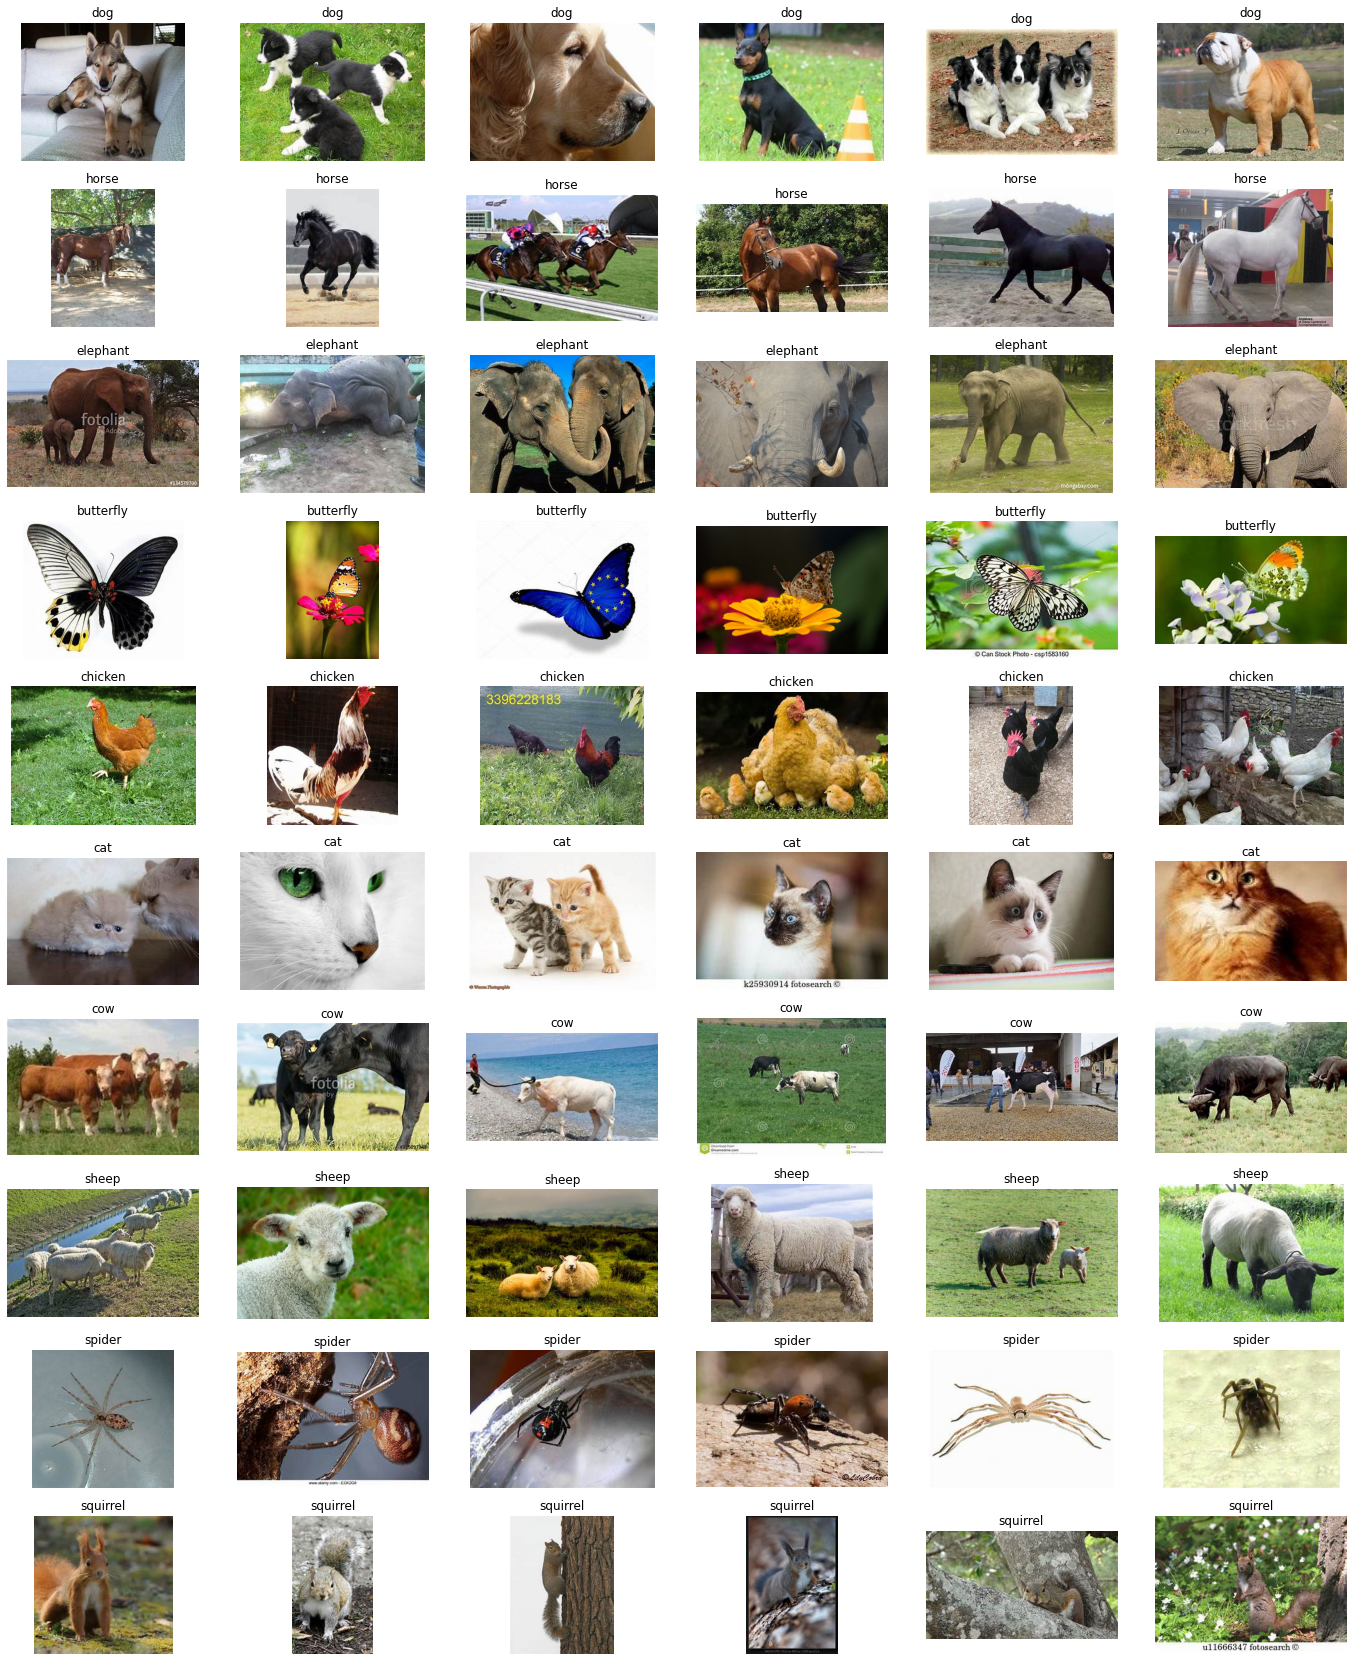

In [5]:
img_list = []
cls_list = []

num_img = 6
num_classes = len(classes)

for class_ in classes:
    
    for i, img in enumerate(os.listdir(path + class_)):           
        img_path = path + class_ + "/" + img
        img = Image.open(img_path)
        img_list.append(img)
        cls_list.append(class_)
        if i == num_img - 1: break


plt.figure(figsize=(24,30))
for j in range(num_classes * num_img):
    plt.subplot(num_classes, num_img, j+1)
    plt.axis('off')
    plt.imshow(img_list[j])
    plt.title(translate[cls_list[j]])

In [6]:
img_path_list = []
img_classes_list = []
skiped_list = []
for class_ in classes: 
    for img in os.listdir(path + class_):
        if (img[-4:] != "jpeg"):
            skiped_list.append(img)
            continue
        img_path = path + class_ + "/" + img
        img_path_list.append(img_path)
        img_classes_list.append(translate_class2num[class_])
        
print(len(img_path_list), len(img_classes_list))
print("Skipped:", len(skiped_list))
#and (img[-3:] != "jpg")
pd.value_counts(img_classes_list)

24209 24209
Skipped: 1970


0    4863
8    4497
4    3098
1    2623
6    1866
9    1862
3    1650
7    1444
5    1227
2    1079
dtype: int64

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(img_path_list, img_classes_list, test_size=0.1, random_state=42)
print(len(x_train), len(x_valid))

21788 2421


In [8]:
### RESNET ## MobilNet

preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    
    #T.RandomCrop((28, 28)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-40, 40)),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    #T.RandomVerticalFlip(p=0.5),
    
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_valid = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class AnimalsDataset(Dataset):
    
    def __init__(self, imgs_list, class_list, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_list = class_list
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        input_image = Image.open(image_path)

        if self.transforms:
            image = self.transforms(input_image)   

        label = torch.from_numpy(np.array(self.class_list[index]))
        
        return image, label    
        
    def __len__(self):
        return len(self.imgs_list)


In [9]:
train_dataset = AnimalsDataset(x_train, y_train, preprocess )
valid_dataset = AnimalsDataset(x_valid, y_valid, preprocess_valid)

batch_size = 16

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle=False,
)

In [10]:
# Iterations number
iter_num =  math.ceil(len(train_dataset) / batch_size)
iter_valid_num =  math.ceil(len(valid_dataset) / batch_size)
print(iter_num, iter_valid_num)

1362 152


# Model

In [11]:

model_resnet18 = models.resnet18()
model_resnet18.load_state_dict(torch.load("../input/resnet18f37072fd/resnet18-f37072fd.pth"))

#model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

model_resnet18.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

#model_resnet18

In [12]:
class ConvSoftmaxClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize layer
        self.mlp = model_resnet18
        self.activation = nn.Softmax(dim=1)

    # Required: overrides __call__
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return self.activation(self(x))

    def predict(self, x):
        return torch.argmax(self.activation(self(x)), dim=1)

classifier = ConvSoftmaxClassifier(num_classes+1).to(device)

In [13]:
loss = nn.CrossEntropyLoss()

# Gradient descent update rule
optimizer = torch.optim.SGD(classifier.parameters(), # Put parameters to optimize here 
                            lr=0.02, # Learning rate
                            momentum=0.9,
                            weight_decay=1e-5 # Put L2 regularization here
            )

In [14]:
n_epochs = 25

train_history = []
valid_history = []

for i in range(n_epochs):
    # Iterate over batches

    classifier.train()
    epoch_loss = 0
    iter_loss = 0
    for j, (x, y) in enumerate(train_loader):
        # Forward
        x = x.to(device)
        y = y.to(device)
        y_hat = classifier(x)

        # Compute loss
        loss_batch = loss(y_hat, y)
        
        epoch_loss += loss_batch.item()
        
        iter_loss += loss_batch.item()
        
        if (j > 0) and (j % 100 == 0):
            print("Iter # {}, loss = {:3}".format(j, iter_loss))
            iter_loss = 0
        
        #pbar.set_postfix({'loss_batch': float(loss_batch.item())})

        optimizer.zero_grad() # Do not forget this!
        # Backward: propagate gradients
        loss_batch.backward()
        
        # Update
        optimizer.step()
        
        #break
    
    # Validation    
    with torch.no_grad():
        classifier.eval() # Equivalent: classifier.eval()

        valid_loss = 0
        for x, y in valid_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            y_hat = classifier(x)
            loss_batch = loss(y_hat, y)            
            valid_loss += loss_batch.item()
    
    train_history.append(epoch_loss)
    valid_history.append(valid_loss)
    
    print("Epoch # {}, Train loss = {:3}, Valid loss = {:3}".format(i+1, epoch_loss, valid_loss))

Iter # 100, loss = 311.471616089344
Iter # 200, loss = 253.83145403862
Iter # 300, loss = 224.56644821166992
Iter # 400, loss = 225.7045373916626
Iter # 500, loss = 219.12334322929382
Iter # 600, loss = 207.4838970899582
Iter # 700, loss = 204.2180758714676
Iter # 800, loss = 195.383265376091
Iter # 900, loss = 185.9980912208557
Iter # 1000, loss = 181.27163517475128
Iter # 1100, loss = 172.29816782474518
Iter # 1200, loss = 169.48220455646515
Iter # 1300, loss = 162.62371760606766
Epoch # 1, Train loss = 2809.80326962471, Valid loss = 250.31977903842926
Iter # 100, loss = 154.15324527025223
Iter # 200, loss = 160.37791180610657
Iter # 300, loss = 156.51845455169678
Iter # 400, loss = 145.29648798704147
Iter # 500, loss = 144.7854567170143
Iter # 600, loss = 140.71358513832092
Iter # 700, loss = 133.95095920562744
Iter # 800, loss = 134.21764719486237
Iter # 900, loss = 126.88105934858322
Iter # 1000, loss = 123.77194619178772
Iter # 1100, loss = 124.8404289484024
Iter # 1200, loss = 1

Text(0.5, 1.0, 'Valid Loss')

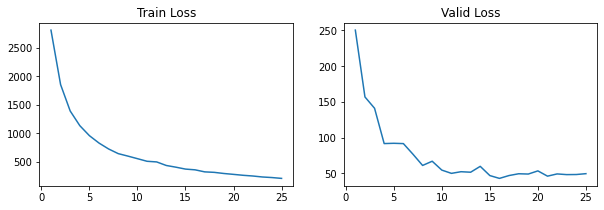

In [15]:
#Train history

idx = [i for i in range(1,len(train_history)+1)]

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(idx, train_history)
plt.title("Train Loss")


plt.subplot(1, 2, 2)
plt.plot(idx, valid_history)
plt.title("Valid Loss")

In [16]:
classifier.eval()

with torch.no_grad():

    test_preds = []
    test_labels = []
    for x, y in valid_loader:
        x = x.cuda()
        y = y.cuda()
        test_labels += list(y.cpu())#.cpu())
        pred = classifier.predict(x).cpu()
        
        test_preds += list(pred)#.cpu())

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       524
           1       0.94      0.86      0.90       263
           2       0.81      0.97      0.88       117
           3       0.88      0.95      0.92       184
           4       0.94      0.94      0.94       289
           5       0.84      0.92      0.88       110
           6       0.82      0.84      0.83       177
           7       0.87      0.82      0.84       142
           8       0.97      0.95      0.96       431
           9       0.93      0.89      0.91       184

    accuracy                           0.91      2421
   macro avg       0.89      0.90      0.90      2421
weighted avg       0.91      0.91      0.91      2421



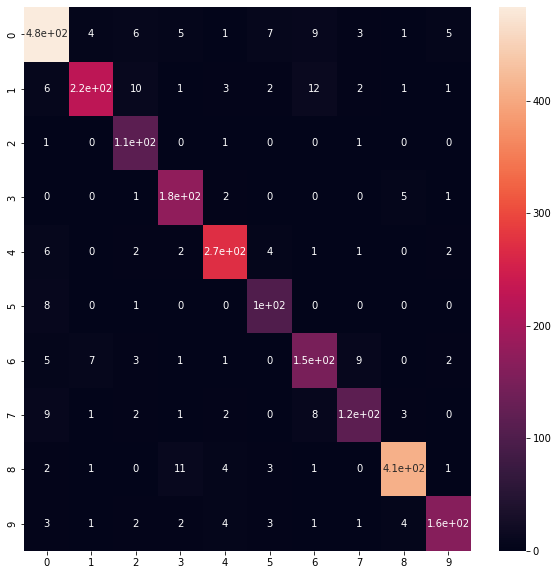

In [17]:
# Confusion matrix

plt.figure(figsize=(10,10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True)
plt.show()